Homework 5:  CSCI 6364/4364

In this assignment, you will become familiar with the deep learning library Pytorch through the construction of a feed-forward neural network and a convolutional neural network applied to the MNIST dataset.  In various parts of the notebook, there will be places to fill in.

In [1]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
SEED = 1
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

Download and use the MNIST dataset from Homework 1.

In [2]:
dataset_filename = "data_mnist.csv"
df = pd.read_csv(dataset_filename)
print(df.shape)

(42000, 785)


In [3]:
y = df['label'].values
X =  df.drop(['label'], axis=1).values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [4]:
print(y_test.shape)

(6300,)


In [5]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

In [6]:
X.shape

(42000, 784)

In [7]:
input_dim = X.shape[-1]
output_dim = 10
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dim,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,output_dim)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)
 
mlp = MLP()
print(mlp)

MLP(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


In [8]:
def fit(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss()
    EPOCHS = 5
    model.train()
    for epoch in range(EPOCHS):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            # Total correct predictions
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            #print(correct)
            if batch_idx % 50 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

In [9]:
fit(mlp, train_loader)

Epoch : 0 [0/35700 (0%)]	Loss: 15.878024	 Accuracy:3.125%
Epoch : 0 [1600/35700 (4%)]	Loss: 0.591852	 Accuracy:67.463%
Epoch : 0 [3200/35700 (9%)]	Loss: 0.783195	 Accuracy:75.526%
Epoch : 0 [4800/35700 (13%)]	Loss: 0.529619	 Accuracy:79.222%
Epoch : 0 [6400/35700 (18%)]	Loss: 0.179729	 Accuracy:81.685%
Epoch : 0 [8000/35700 (22%)]	Loss: 0.625295	 Accuracy:83.329%
Epoch : 0 [9600/35700 (27%)]	Loss: 0.693083	 Accuracy:84.541%
Epoch : 0 [11200/35700 (31%)]	Loss: 0.217769	 Accuracy:85.328%
Epoch : 0 [12800/35700 (36%)]	Loss: 0.233654	 Accuracy:85.910%
Epoch : 0 [14400/35700 (40%)]	Loss: 0.217472	 Accuracy:86.537%
Epoch : 0 [16000/35700 (45%)]	Loss: 0.513734	 Accuracy:87.063%
Epoch : 0 [17600/35700 (49%)]	Loss: 0.524939	 Accuracy:87.511%
Epoch : 0 [19200/35700 (54%)]	Loss: 0.113853	 Accuracy:87.760%
Epoch : 0 [20800/35700 (58%)]	Loss: 0.413980	 Accuracy:88.110%
Epoch : 0 [22400/35700 (63%)]	Loss: 0.291666	 Accuracy:88.405%
Epoch : 0 [24000/35700 (67%)]	Loss: 0.313035	 Accuracy:88.765%
Epoch

9
tensor(9)


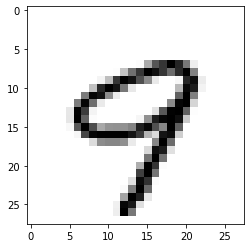

In [10]:
mlp.eval()              # turn the model to evaluate mode
index = 200
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
image = torch_X_test[index].float().unsqueeze(0)
true_label = y_test[index]
with torch.no_grad():     # does not calculate gradient
    class_index = mlp(image).argmax()   #gets the prediction for the image's class
plt.imshow(image.numpy().reshape(28,28,1), cmap='gray_r');
print(true_label)
print(class_index)

In [11]:
torch_X_train = torch_X_train.view(-1, 1,28,28).float()
torch_X_test = torch_X_test.view(-1,1,28,28).float()
print(torch_X_train.shape)
print(torch_X_test.shape)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

torch.Size([35700, 1, 28, 28])
torch.Size([6300, 1, 28, 28])


In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
 
cnn = CNN()
print(cnn)

it = iter(train_loader)
X_batch, y_batch = next(it)
print(cnn.forward(X_batch).shape)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
torch.Size([32, 10])


In [13]:
fit(cnn,train_loader)

Epoch : 0 [0/35700 (0%)]	Loss: 17.491018	 Accuracy:9.375%
Epoch : 0 [1600/35700 (4%)]	Loss: 1.703722	 Accuracy:17.770%
Epoch : 0 [3200/35700 (9%)]	Loss: 1.009868	 Accuracy:34.251%
Epoch : 0 [4800/35700 (13%)]	Loss: 1.154488	 Accuracy:45.840%
Epoch : 0 [6400/35700 (18%)]	Loss: 1.056982	 Accuracy:54.011%
Epoch : 0 [8000/35700 (22%)]	Loss: 0.627523	 Accuracy:59.512%
Epoch : 0 [9600/35700 (27%)]	Loss: 0.358505	 Accuracy:63.320%
Epoch : 0 [11200/35700 (31%)]	Loss: 0.132880	 Accuracy:66.524%
Epoch : 0 [12800/35700 (36%)]	Loss: 0.220809	 Accuracy:69.038%
Epoch : 0 [14400/35700 (40%)]	Loss: 0.289793	 Accuracy:71.161%
Epoch : 0 [16000/35700 (45%)]	Loss: 0.346210	 Accuracy:72.861%
Epoch : 0 [17600/35700 (49%)]	Loss: 0.682445	 Accuracy:74.399%
Epoch : 0 [19200/35700 (54%)]	Loss: 0.371773	 Accuracy:75.655%
Epoch : 0 [20800/35700 (58%)]	Loss: 0.149076	 Accuracy:76.858%
Epoch : 0 [22400/35700 (63%)]	Loss: 0.321230	 Accuracy:77.920%
Epoch : 0 [24000/35700 (67%)]	Loss: 0.369620	 Accuracy:78.812%
Epoch

6
tensor(6)


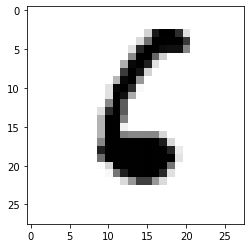

In [14]:
cnn.eval()              # turn the model to evaluate mode
index = 100
torch_X_test = torch_X_test.view(-1,1,28,28).float().type(torch.LongTensor)
image = torch_X_test[index].float().unsqueeze(0)
true_label = y_test[index]
with torch.no_grad():     # does not calculate gradient
    class_index = cnn(image).argmax()   #gets the prediction for the image's class
plt.imshow(image.numpy().reshape(28,28,1), cmap='gray_r');
print(true_label)
print(class_index)

Describe the performance of the MLP and CNN models? Performance can include training time, accuracy, etc.

## MLP vs. CNN
The training time for MLP is much faster than for CNN. The accuracy of the model also increases faster for MLP than for CNN, implying that it converges faster. If we look at the output where each line represents 50 batches, both models start at around 15%, and MLP jumps to about 60-70% in the next printed line. CNN takes about 7 lines to get to that value. Additionally, MLP seems to achieve higher accuracy. Even after 150 epochs, the CNN remains at about 96-97% accuracy, while the MLP achieves 99% accuracy. The good performance of the MLP is likely the result of this dataset being simple images that are very similar to each other (same size, similar pixels tend to be the ones that are shaded, etc.). For more complex image tasks, the CNN is likely to outper

Extra Credit: Describe the below code and the output

This code modifies the gradients in the x tensor so it misclassifies a digit. It first gets the model's inference for the image at index 100 by calculating the logit output and getting the argmax. It then loops, and in each iteration calculates the inference/logits/argmax. The first time they are going to be the same as what was calculated before the loop, so it will not satisfy the if statement and thus not break. The code then modifies the logits at the predicted digit index and calculates the loss, updating the gradients. These updates eventually cause the model to update the weights such that the inference for that image, and likely for images similar to that one, to be wrong.

Init idx: 6
9.713150024414062 -9.870042413240299e-05 -9.713248252868652

Job done, breaking
tensor([-2.1283, -2.0920, -2.2709, -2.4545, -2.4132, -2.5092, -2.5033, -2.3471,
        -2.1452, -2.2729])


1

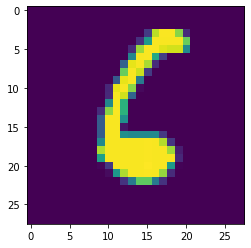

In [30]:
model = cnn
#torch_X_test = torch_X_test.view(-1,1,28,28).float().type(torch.LongTensor)
x = torch_X_test[index].float().clone()
x.requires_grad_(True)
with torch.no_grad():
    logits = model(x.unsqueeze(0)).squeeze()
    IMX = torch.argmax(logits)
print("Init idx:",IMX.item())

lr=.01
while True:
    logits = model(x.unsqueeze(0)).squeeze()
    
    imx = torch.argmax(logits)
    if imx!=IMX: 
        print("Job done, breaking")
        break
    y = logits.clone()
    y[imx] = -99
    loss = logits.max() - y.max() 
    loss.backward()
    
    
    x.data.sub_(lr*x.grad.data)
    print(loss.item(),logits.max().item(), y.max().item() )
    print()
    x.grad.data.zero_()
    x.data.sub_(x.data.min())
    x.data.mul_(1/x.data.max())
    
with torch.no_grad():
    print(model(x.unsqueeze(0)).squeeze())

plt.imshow(x.detach().cpu().numpy().transpose(1,2,0).reshape(28,28));torch.argmax(model(x.unsqueeze(0))).item()